# Lenapy for spherical harmonics and gravity data
Lenapy includes functions to read and process spherical harmonics and gravity data.

These function are accessible to be applied to a dataset using *xarray* accessor. With a xr.Dataset instance ds, one can call the function to be applied onto ds with **ds.lnharmo.func()**.

The corresponding functions are located in the package *lenapy.utils* (for **lnharmo** it corresponds to function from *lenapy.utils.harmo* and *lenapy.utils.gravity*).

## Imports
Lenapy is an overlayer of xarray. For using lenapy fonctionnalities you need to import both xarray and lenapy.

In [1]:
import xarray as xr
import lenapy

import os
import numpy as np

# for plotting:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

/home/avincent/miniconda3/envs/pluto_lenapy/lib/python3.11/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


## Reading
Reader implemented in lenapy are an overlayer for the *xr.open_dataset()* function of xarray. To use this reader, you need to modify the argument *engine=* with *'lenapyGfc'* or *'lenapyGraceL2'*.

The data are loaded into a dataset with 'clm' and 'slm' variables. If errors information are available they are load into 'eclm' and 'eslm' variables.

Metadata informations are saved into attributs accesible with ds.attrs

### ascii file with .gfc format reading
File that follow the .gfc format can be read with lenapy (https://icgem.gfz-potsdam.de/docs/ICGEM-Format-2023.pdf) using *engine='lenapyGfc'*.

If the model name (in the header of the .gfc file) does not contain date information, use no_date=True.

The reader *'lenapyGfc'* can be given *date_regex* and *date_format* arguments to specify the exact date information. See the function documentation for more details.

**You can download the corresponding files on the [ICGEM website](https://icgem.gfz-potsdam.de/sl/temporal).**

In [2]:
# April 2002 .gfc from GRAZ center
file = '../../data/GSM-2_2002213-2002243_GRAC_COSTG_BF01_0100.gfc'

ds = xr.open_dataset(file, engine='lenapyGfc', no_date=False)
ds

<xarray.Dataset> Size: 266kB
Dimensions:     (l: 91, m: 91, time: 1)
Coordinates:
  * l           (l) int64 728B 0 1 2 3 4 5 6 7 8 ... 82 83 84 85 86 87 88 89 90
  * m           (m) int64 728B 0 1 2 3 4 5 6 7 8 ... 82 83 84 85 86 87 88 89 90
  * time        (time) datetime64[ns] 8B 2002-08-16T12:00:00
Data variables:
    clm         (l, m, time) float64 66kB ...
    slm         (l, m, time) float64 66kB ...
    eclm        (l, m, time) float64 66kB ...
    eslm        (l, m, time) float64 66kB ...
    begin_time  (time) datetime64[ns] 8B ...
    end_time    (time) datetime64[ns] 8B ...
    exact_time  (time) datetime64[ns] 8B ...
Attributes:
    product_name:            GSM-2_2002213-2002243_GRAC_COSTG_BF01_0100
    earth_gravity_constant:  398600441500000.0
    radius:                  6378136.3
    norm:                    4pi
    tide_system:             tide_free
    max_degree:              90
    errors:                  empirical
    modelname:               GSM-2_2002213-2002243_GRAC_COSTG_BF01_0100

The dataset is composed of three dimensions : **l** for the degree dimension, **m** for the order dimension and **time** for the temporal dimension.

It contains **clm** and **slm** variables that are 3D array corresponding to Stokes coefficients. If the corresponding informations are available in the original file, the formal errors of Stokes coefficients are loaded in variables **eclm** and **eslm** and temporal informations corresponding of the first/last date of the data used to create the file as well as the exact time of the date between first and last date are stored.

The attributes of the dataset (**ds.attrs**) contain metadata information related to the Stokes coefficients

### Multifiles
We can also use xr.open_mfdatasets() to open multiple files.

For example you can load a list of the files in a directory with

> files = os.listdir(folder_path)
> 
> ds = xr.open_mfdataset(files, engine='lenapyGfc', combine_attrs="drop_conflicts")

### ascii file with Level 2 GRACE format
File from GRACE Level-2 SDS centers (CSR, GFZ, JPL) and from CNES can be read with engine='lenapyGraceL2'.

**You can download CNES files [here](https://grace.obs-mip.fr/variable-models-grace-lageos/grace-solutions-release-05/rl05-download-products/) or CSR/GFZ/JPL files [here](https://podaac.jpl.nasa.gov/dataset/GRACEFO_L2_CSR_MONTHLY_0062).**

The reading works for compressed files. For example :
> file_csr = os.path.join(folder_path, 'GSM-2_2002213-2002243_GRAC_UTCSR_BB01_0600.gz'
>
> ds_csr = xr.open_dataset(file_csr, engine='lenapyGraceL2')

## Apply coefficient corrections
For the following demonstration, we use COST-G products (GRACE RL01 + GRACE-FO operational RL02) between 2002 and December 2022.

In [3]:
# Dataset with COST-G months of GRACE and GRACE-FO
ds_path = '../../data/COSTG_n12_2002_2022.nc'

ds = xr.open_dataset(ds_path)

### Read TN14
Both TN14 and TN13 dataset can be download here : [https://podaac.jpl.nasa.gov/gravity/grace-documentation#TechnicalNotes](https://podaac.jpl.nasa.gov/gravity/grace-documentation#TechnicalNotes)

$C_{2,0}$ coefficient has a large uncertainty for GRACE products compared to other determination with SLR satellites. It is the same for $C_{3,0}$ coefficient after August 2016 and the accelerometer failure of one GRACE and GRACE-FO satellite.

To improve the quality of GRACE products, supplementary dataset, TN14, that can be used to corrected these coefficients is delivered by the processing centers.

The function read the time-series with or without the mean value using the argument **rmmean=** (False by default).

In [4]:
from lenapy.readers.gravi_reader import read_tn14, read_tn13

ds_C20_C30 = read_tn14('../../data/TN-14_C30_C20_GSFC_SLR.txt', rmmean=False)

To be really precise, you need to change the Earth radius associated to the coefficients used for the correction so that it correspond to the constant associated the the GRACE product used (COST-G here) and then you can replace the coefficients in the product.

The function **change_reference()** read the *'radius'* and *'earth_gravity_constant'* initial and final variables from the dataset.attrs or they can be given with optionnal attributes of the function.

**Note that the modification for coefficient $C_{2,0}$ and $C_{3,0}$ is negligeable**

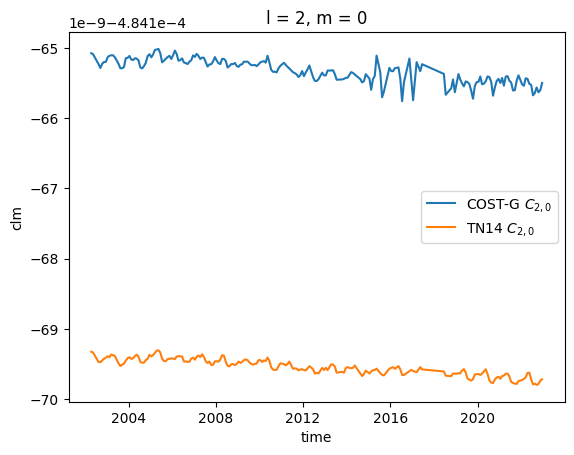

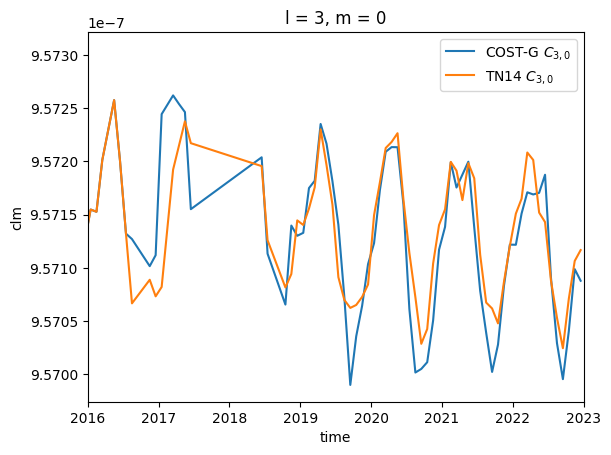

In [5]:
from lenapy.utils.gravity import change_reference

ds_C20_C30 = change_reference(ds_C20_C30, new_radius=ds.attrs['radius'], new_earth_gravity_constant=ds.attrs['earth_gravity_constant'])

ds.clm.sel(l=2, m=0).plot(label='COST-G $C_{2,0}$')
# Correct C20
ds.clm.loc[{'l':2, 'm':0}] = ds_C20_C30.clm.sel(l=2, m=0, time=ds.time)
ds.clm.sel(l=2, m=0).plot(label='TN14 $C_{2,0}$')
plt.legend()

plt.figure()
ds.clm.sel(l=3, m=0).plot(label='COST-G $C_{3,0}$')
# Correct C30 after July 2016 for GRACE and GRACE-FO (start on August 2016)
ds.clm.loc[{'l':3, 'm':0, 'time':slice('2016-08-01', None)}] = ds_C20_C30.clm.sel(l=3, m=0, time=slice('2016-08-01', str(ds.time.values[-1])[:10]))
ds.clm.sel(l=3, m=0).plot(label='TN14 $C_{3,0}$')
plt.xlim(np.datetime64('2016-01-01'), np.datetime64('2023-01-01'))
plt.legend()

### Read TN13
GRACE products does not contain degree 1 coefficients and are then referenced with an origin corresponding to the center of mass of the Earth. To add degree 1 coefficient, processing centers are delevering TN13, degree 1 time-series product. Each SDS centers has is own TN13 file that is generated with center products using Sun et al. 2016 and Swenson et al. 2008.

To read and apply the correction

> ds_deg1 = lenapy.readers.gravi_reader.read_tn13('TN-13_GEOC_CSR_RL06.2.txt')
>
> ds.clm.loc[{'l':1, 'm':0}] = ds_deg1.clm.sel(l=1, m=0, time=ds.time)
>
> ds.clm.loc[{'l':1, 'm':1}] = ds_deg1.clm.sel(l=1, m=1, time=ds.time)
>
> ds.slm.loc[{'l':1, 'm':1}] = ds_deg1.slm.sel(l=1, m=1, time=ds.time)

## Projecting spherical harmonics into spatial grid
### Details of the projection

$C_{l,m}$ and $S_{l,m}$ coefficients can be projected on a grid with an associated radius $R$ using the formula:

$\eta(\lambda, \theta) = \sum_{l=0}^{l_{max}} \zeta_l \sum_{m=0}^{l} \lbrack C_{l,m}\cos(m\lambda) + S_{l,m}\sin(m\lambda)\rbrack P_{l,m}(\cos \theta)$

$\lambda$ is the longitude, $\theta$ is the colatitude, $P_{l,m}$ are normalized Legendre polynomials.

By default, the $R$ correspond to **ds.attrs['radius']** but it can be changed with **lenapy.utils.gravi.change_reference()**.

#### EWH (default unit)
To project onto Equivalent Water Height unit, in the above formula:

$\zeta_l = \frac{R\rho_{earth}}{3\rho_{water}}~\frac{2l+1}{1+k_l}$

With $\rho_{earth}$ the mean earth density, $\rho_{water}$ the water density, $k_l$ the potential loading love numbers and $R$ the Earth mean equatorial radius.

The using R correspond to **ds.attrs['radius']**.

#### Other units
You can also transform Stokes coefficients into different units with appropriate $\zeta_l$. 

Here is a list of the units :
- 'mewh' for meters of EWH
- 'geoid' for millimeters geoid height
- 'microGal' for microGal gravity perturbation
- 'potential' for meters^2.seconds^-2
- 'pascal' for equivalent surface pressure
- 'mvcu' for meters viscoelastic crustal uplift
- 'mecu' for meters elastic crustal deformation

#### Radius of the grid
May arrive in the future.

### Function for the conversion
The conversion can be used as a method onto the dataset with an accessor: **ds.lnharmo.to_grid()**

This writing is equivalent to **sh_to_grid(ds)** (located in *lenapy.utils.harmo*) so to see the argument that might be used look at the documentation of this function.

You can change the degree $l$ and order $m$ that are used for the conversion, change the longitude and the latitude of projection and use an ellispoidal Earth. Using **kwargs, you can also pass parameters to **l_factor_conv** to change the used constants in the unit conversion.

In [6]:
from lenapy.utils.harmo import sh_to_grid

# by default, unit='mewh' for meters of equivalent water height
grid = ds.lnharmo.to_grid()

# other unit can be used 'geoid', 'microGal', 'pascal', ...

#equivalent to
sh_to_grid(ds)

<xarray.DataArray (latitude: 180, longitude: 360, time: 216)> Size: 112MB
array([[[11630332.05892523, 11630332.06934252, 11630332.0597365 , ...,
         11630332.17015108, 11630332.16923063, 11630332.17156417],
        [11630331.75538494, 11630331.7658193 , 11630331.75623467, ...,
         11630331.86629094, 11630331.86535558, 11630331.867679  ],
        [11630331.4635765 , 11630331.47402774, 11630331.46446525, ...,
         11630331.57416799, 11630331.5732176 , 11630331.57553061],
        ...,
        [11630333.03909915, 11630333.04946414, 11630333.03979841, ...,
         11630333.15131551, 11630333.15043901, 11630333.1528012 ],
        [11630332.70087009, 11630332.71125268, 11630332.7016061 , ...,
         11630332.81275122, 11630332.8118602 , 11630332.81421313],
        [11630332.37411554, 11630332.38451557, 11630332.3748889 , ...,
         11630332.48566647, 11630332.4847608 , 11630332.48710418]],

       [[11630336.80424296, 11630336.81584806, 11630336.80111835, ...,
         11630336.87797578, 11630336.87802749, 11630336.88231505],
        [11630335.97134556, 11630335.98300739, 11630335.96834323, ...,
         11630336.04408688, 11630336.04409055, 11630336.0483456 ],
        [11630335.17584039, 11630335.18755839, 11630335.17296209, ...,
         11630335.247602  , 11630335.24755729, 11630335.25177895],
...
        [11631013.40432211, 11631013.40165253, 11631013.4877568 , ...,
         11631013.46079941, 11631013.4726309 , 11631013.4255675 ],
        [11631014.06285   , 11631014.06016933, 11631014.14607235, ...,
         11631014.11848184, 11631014.1303246 , 11631014.08329308],
        [11631014.73911098, 11631014.73641958, 11631014.82211618, ...,
         11631014.79386831, 11631014.80572307, 11631014.75872547]],

       [[11630980.07142463, 11630980.06895791, 11630980.1456611 , ...,
         11630980.07045177, 11630980.08356325, 11630980.04024149],
        [11630980.33002579, 11630980.32755487, 11630980.40418232, ...,
         11630980.3286939 , 11630980.34181159, 11630980.29850394],
        [11630980.5954498 , 11630980.59297472, 11630980.66952498, ...,
         11630980.59375007, 11630980.60687415, 11630980.56358121],
        ...,
        [11630979.337243  , 11630979.33478925, 11630979.41171071, ...,
         11630979.3372936 , 11630979.35038752, 11630979.30702721],
        [11630979.57496637, 11630979.57250824, 11630979.64935845, ...,
         11630979.57468484, 11630979.58778443, 11630979.54443634],
        [11630979.81971559, 11630979.81725314, 11630979.89403059, ...,
         11630979.81909289, 11630979.83219833, 11630979.78886309]]])
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 2kB 2002-04-16 ... 2022-12-16T12:00:00
Attributes:
    units:                   mewh
    max_degree:              12
    radius:                  6378136.3
    earth_gravity_constant:  398600441500000.0

### Using grid variable

The grid output is a xr.DataArray depending on longitude, latitude (and time if the dimension exist). It can be used as a normal DataArray.

The constant Earth gravity field is dominated by $C_{2,0}$ coefficient so the dominant variations at one date correspond to Earth oblateness.

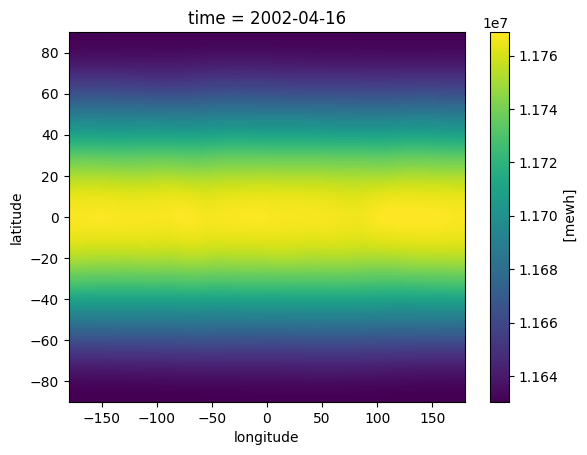

In [7]:
grid.isel(time=0).plot()

### Access residuals and geographic plot
To go futher than an image of the Earth oblatness ($C_{2,0}$), we can access the residual of the constant gravity field.

To study time-variable gravity field we need to remove a mean field that gives us access to the residuals values.

It can be done by removing the mean of each Stokes coefficient, or the mean of each grid point, or by substracting an a priori field (e.g. GGM05C for CSR product).

You can also see an example of how to plot geographical maps with matplotlib / xarray.

In [8]:
# create grid with residual values
grid_residual = (ds - ds.mean(dim='time')).isel(time=0).lnharmo.to_grid()

You can then visualise the result

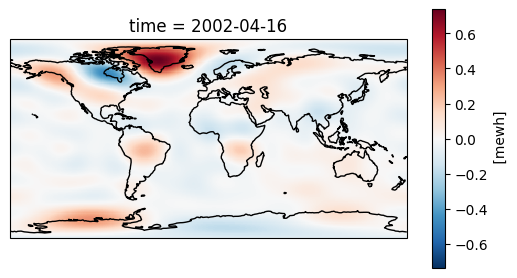

In [9]:
fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
grid_residual.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.7})
axis.coastlines()

### Going back to Spherical Harmonics
From the spatial values in a DataArray, we can estimate the Stokes coefficients back with **da.lnharmo.to_sh()**

This writing is equivalent to **grid_to_sh(da)** (located in *lenapy.utils.harmo*) so to see the argument that might be used look at the documentation of this function.

You can change the degree $l$ and order $m$ that will be estimated and use an ellispoidal Earth. Using **kwargs, you can also pass parameters to **l_factor_conv** to change the used constants in the unit conversion.

In [10]:
grid_residual.lnharmo.to_sh(lmax=60)

<xarray.Dataset> Size: 61kB
Dimensions:  (l: 61, m: 61)
Coordinates:
  * l        (l) int64 488B 0 1 2 3 4 5 6 7 8 9 ... 52 53 54 55 56 57 58 59 60
  * m        (m) int64 488B 0 1 2 3 4 5 6 7 8 9 ... 52 53 54 55 56 57 58 59 60
    time     datetime64[ns] 8B 2002-04-16
Data variables:
    clm      (l, m) float64 30kB -4.21e-14 0.0 0.0 ... 8.301e-28 -3.514e-28
    slm      (l, m) float64 30kB 0.0 0.0 0.0 ... -2.675e-27 4.305e-27 1.3e-27
Attributes:
    gm_earth:    398600441500000.0
    a_earth:     6378137.0
    max_degree:  60
    norm:        4pi

## Manipulating Spherical harmonics datasets

### Operation of spherical harmonics dataset
You may have seen that I can apply operation like power (**2) over ds.lnharmo object. In fact several methods have been overwriten to be applied only over **ds.clm** and **ds.slm** variables in the dataset.

By this way you can **add, subtract, multiply** dataset with spherical harmonics variables by applying the operation onto ds.lnharmo object.

Note that you can not apply the divide operation (however, you can multiply by $\frac{1}{x}$).

In [11]:
ds_sum = ds.isel(time=slice(0)).lnharmo + ds.isel(time=slice(1))

ds_mean = (ds.isel(time=slice(0)).lnharmo + ds.isel(time=slice(1))).lnharmo * 0.5 

### Plot based on spherical harmonics
#### Time-serie plot
You can just the time-series corresponding to one coefficient with ds.sel(l=l, m=m).plot()

If you give argument to the **.plot()** function they are interpreted as plot argument like 'label' or 'color'.

After the plot, you can modify the matplotlib figure as usual.

Text(0.5, 1.0, '$C_{2,0}$')

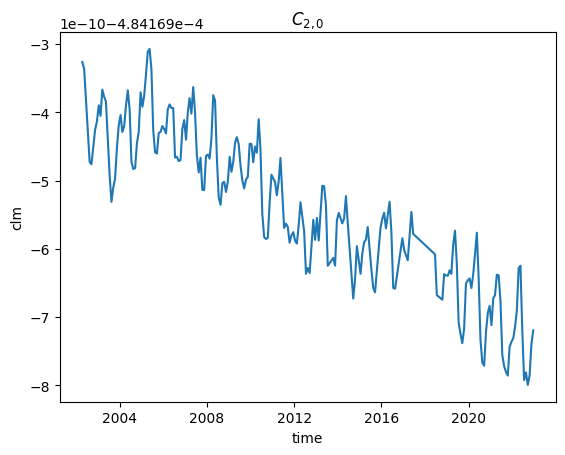

In [12]:
# time series of one coefficient
ds.isel(l=2, m=0).clm.plot()
plt.title("$C_{2,0}$")

#### Triangular plot
With a spherical harmonics dataset, we might try to look at it in terms of SH coefficients amplitude with the function **ds.lnharmo.plot_hs()** that call the function located in *lenapy.plots.plotting*.

You first need to create a dataset without extra dimension (reduce the time with a .sel(time=...) or a .mean('time') or other). Then you can plot the dataset.

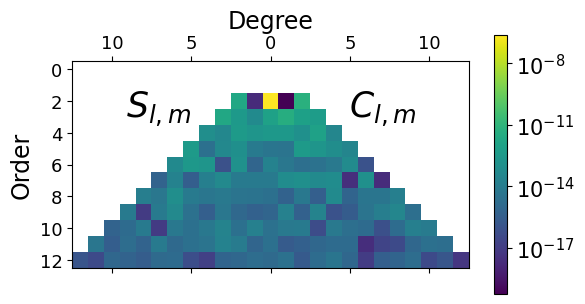

In [13]:
import matplotlib.ticker as ticker

# reduce the dataset to one date
ds_square = (ds.isel(time=0).lnharmo)**2

# triangular plot
ax = ds_square.lnharmo.plot_hs(norm='log', lmax=12)

#### HS power plot
You can plot the degree power for a certain date with the function **plot_power_hs()** located in *lenapy.plots.plotting*.

You first need to create a dataset without extra dimension (reduce the time with a .sel(time=...) or other). Then you can plot the dataset.

Text(0.5, 1.0, 'Degree power spectrum')

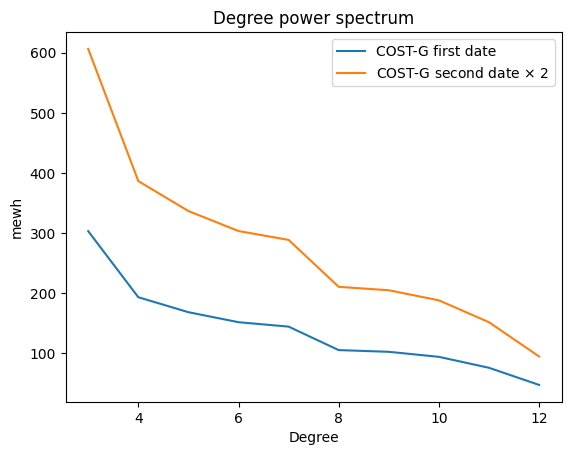

In [14]:
from lenapy.plots.plotting import plot_power

# plot the degree power
plot_power(ds.isel(time=0), lmin=3, label='COST-G first date')
plot_power(ds.isel(time=1).lnharmo*2, lmin=3, label=r'COST-G second date $\times$ 2')
plt.legend()
plt.title("Degree power spectrum")

## Writing .gfc file
You can write a .gfc file with **ds.lnharmo.to_gfc()**. The function **dataset_to_gfc** located in *lenapy.writers.gravi_writer* allows to write .gfc ascii file from a spherical harmonics dataset.

The writer will inspect **ds.attrs** to create the header of the gfc file. If values are not contained in **ds.attrs** or in the function parameters, default values are used.

First, you need to create a dataset without extra dimensions by reducing the 'time' dimension using methods like **.sel(time=...)** or **.mean('time')**.

In [15]:
example_path = 'tmp/test.gfc'

# Write the spherical harmonics data of the first time slice to a .gfc file
ds.isel(time=0).lnharmo.to_gfc(example_path)